In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import precision_score, recall_score, fbeta_score, make_scorer
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from scipy.stats import skew
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import shap
warnings.filterwarnings('ignore')

Chargement des fichiers

In [2]:
eval_df = pd.read_csv("data/extrait_eval.csv")
sirh_df = pd.read_csv("data/extrait_sirh.csv")
sondage_df = pd.read_csv("data/extrait_sondage.csv")

Nettoyage du nom des colonnes

In [3]:
sirh_df = sirh_df.rename(columns={'nombre_heures_travailless' : 'nombre_heures_travaillees', 'annee_experience_totale': 'annees_experience_totale'})


In [4]:
eval_df = eval_df.rename(columns={
  'augementation_salaire_precedente' : 'augmentation_salaire_precedente', 
})

In [5]:
sondage_df = sondage_df.rename(columns={
  'annes_sous_reponsable_actuel' : 'annees_sous_reponsable_actuel'
})

### 1. Un DataFrame central, issu d’une jointure entre les fichiers de départ.

eval_number => id_employee => code_sondage

In [6]:
eval_df['id_employee'] = eval_df["eval_number"].str.extract('(\d+)').astype(int)
eval_df.head()

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augmentation_salaire_precedente,id_employee
0,2,3,2,4,1,1,E_1,3,Oui,11 %,1
1,3,2,2,2,4,3,E_2,4,Non,23 %,2
2,4,2,1,3,2,3,E_4,3,Oui,15 %,4
3,4,3,1,3,3,3,E_5,3,Oui,11 %,5
4,1,3,1,2,4,3,E_7,3,Non,12 %,7


In [7]:
sondage_df['id_employee'] = sondage_df["code_sondage"].replace("00000", "")
sondage_df.head()

,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,id_employee
0,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5,1
1,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7,2
2,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0,4
3,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0,5
4,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2,7


INNER JOIN => Je veux uniquement les employés qui ont des données complètes dans les 3 csv

In [8]:
full_df = sirh_df.merge(eval_df, left_on="id_employee", right_on="id_employee", how="inner").merge(sondage_df, on="id_employee", how="inner")
full_df.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travaillees,annees_experience_totale,...,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,...,3,1,4,2,2,Autre,Y,Occasionnel,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,...,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,...,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2


In [9]:
full_df.columns

Index(['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital',
       'departement', 'poste', 'nombre_experiences_precedentes',
       'nombre_heures_travaillees', 'annees_experience_totale',
       'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel',
       'satisfaction_employee_environnement', 'note_evaluation_precedente',
       'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail',
       'satisfaction_employee_equipe',
       'satisfaction_employee_equilibre_pro_perso', 'eval_number',
       'note_evaluation_actuelle', 'heure_supplementaires',
       'augmentation_salaire_precedente', 'a_quitte_l_entreprise',
       'nombre_participation_pee', 'nb_formations_suivies',
       'nombre_employee_sous_responsabilite', 'code_sondage',
       'distance_domicile_travail', 'niveau_education', 'domaine_etude',
       'ayant_enfants', 'frequence_deplacement',
       'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel'],
      dtype='object')

### 2. Des cellules au sein du notebook pour calculer des statistiques descriptives sur les fichiers de départ et le fichier central, dans l’objectif de faire ressortir des différences clés entre les employés.


a. extrait_eval.csv

In [10]:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   satisfaction_employee_environnement        1470 non-null   int64 
 1   note_evaluation_precedente                 1470 non-null   int64 
 2   niveau_hierarchique_poste                  1470 non-null   int64 
 3   satisfaction_employee_nature_travail       1470 non-null   int64 
 4   satisfaction_employee_equipe               1470 non-null   int64 
 5   satisfaction_employee_equilibre_pro_perso  1470 non-null   int64 
 6   eval_number                                1470 non-null   object
 7   note_evaluation_actuelle                   1470 non-null   int64 
 8   heure_supplementaires                      1470 non-null   object
 9   augmentation_salaire_precedente            1470 non-null   object
 10  id_employee                         

b. extrait_sirh.csv

In [11]:
sirh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id_employee                     1470 non-null   int64 
 1   age                             1470 non-null   int64 
 2   genre                           1470 non-null   object
 3   revenu_mensuel                  1470 non-null   int64 
 4   statut_marital                  1470 non-null   object
 5   departement                     1470 non-null   object
 6   poste                           1470 non-null   object
 7   nombre_experiences_precedentes  1470 non-null   int64 
 8   nombre_heures_travaillees       1470 non-null   int64 
 9   annees_experience_totale        1470 non-null   int64 
 10  annees_dans_l_entreprise        1470 non-null   int64 
 11  annees_dans_le_poste_actuel     1470 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 137.9+ KB


c. extrait_sondage.csv

In [12]:
sondage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   a_quitte_l_entreprise                1470 non-null   object
 1   nombre_participation_pee             1470 non-null   int64 
 2   nb_formations_suivies                1470 non-null   int64 
 3   nombre_employee_sous_responsabilite  1470 non-null   int64 
 4   code_sondage                         1470 non-null   int64 
 5   distance_domicile_travail            1470 non-null   int64 
 6   niveau_education                     1470 non-null   int64 
 7   domaine_etude                        1470 non-null   object
 8   ayant_enfants                        1470 non-null   object
 9   frequence_deplacement                1470 non-null   object
 10  annees_depuis_la_derniere_promotion  1470 non-null   int64 
 11  annes_sous_responsable_actuel        1470 n

d. fichier central 

In [13]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 34 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   id_employee                                1470 non-null   int64 
 1   age                                        1470 non-null   int64 
 2   genre                                      1470 non-null   object
 3   revenu_mensuel                             1470 non-null   int64 
 4   statut_marital                             1470 non-null   object
 5   departement                                1470 non-null   object
 6   poste                                      1470 non-null   object
 7   nombre_experiences_precedentes             1470 non-null   int64 
 8   nombre_heures_travaillees                  1470 non-null   int64 
 9   annees_experience_totale                   1470 non-null   int64 
 10  annees_dans_l_entreprise            

## 3. Identification et nettoyage des colonnes quantitatives et qualitatives

In [14]:
df_normalized = full_df.copy()

# Variable pourcentage pour pouvoir l'utiliser si besoin
df_normalized['augmentation_salaire_precedente'] = df_normalized['augmentation_salaire_precedente'].apply(
    lambda x: float(x.replace(' %', '')) / 100
)

# Remplacer les 'Oui' et 'Y' en 1 et le reste en 0
bool_columns = ['heure_supplementaires', 'a_quitte_l_entreprise', 'ayant_enfants']
for col in bool_columns:
    df_normalized[col] = df_normalized[col].apply(
        lambda x: 1 if x == 'Oui' or x == 'Y' else 0
    )

df_normalized.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travaillees,annees_experience_totale,...,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,0,1,1,1,2,Infra & Cloud,1,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,3,1,2,8,1,Infra & Cloud,1,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,...,3,1,4,2,2,Autre,1,Occasionnel,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,...,3,1,5,3,4,Infra & Cloud,1,Frequent,3,0
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,...,3,1,7,2,1,Transformation Digitale,1,Occasionnel,2,2


In [15]:
df_normalized.describe()

,id_employee,age,revenu_mensuel,nombre_experiences_precedentes,nombre_heures_travaillees,annees_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,...,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,ayant_enfants,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000
mean,1024.865306,36.923810,6502.931293,2.693197,80.0,11.279592,7.008163,4.229252,2.721769,2.729932,...,0.161224,0.793878,2.799320,1.0,1024.865306,9.192517,2.912925,1.0,2.187755,4.123129
std,602.024335,9.135373,4707.956783,2.498009,0.0,7.780782,6.126525,3.623137,1.093082,0.711561,...,0.367863,0.852077,1.289271,0.0,602.024335,8.106864,1.024165,0.0,3.222430,3.568136
min,1.000000,18.000000,1009.000000,0.000000,80.0,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.0,0.000000,0.000000
25%,491.250000,30.000000,2911.000000,1.000000,80.0,6.000000,3.000000,2.000000,2.000000,2.000000,...,0.000000,0.000000,2.000000,1.0,491.250000,2.000000,2.000000,1.0,0.000000,2.000000
50%,1020.500000,36.000000,4919.000000,2.000000,80.0,10.000000,5.000000,3.000000,3.000000,3.000000,...,0.000000,1.000000,3.000000,1.0,1020.500000,7.000000,3.000000,1.0,1.000000,3.000000
75%,1555.750000,43.000000,8379.000000,4.000000,80.0,15.000000,9.000000,7.000000,4.000000,3.000000,...,0.000000,1.000000,3.000000,1.0,1555.750000,14.000000,4.000000,1.0,3.000000,7.000000
max,2068.000000,60.000000,19999.000000,9.000000,80.0,40.000000,40.000000,18.000000,4.000000,4.000000,...,1.000000,3.000000,6.000000,1.0,2068.000000,29.000000,5.000000,1.0,15.000000,17.000000


In [16]:
colonnes_quantitatives = df_normalized.select_dtypes(include=['int64', 'float64']).columns.tolist()
colonnes_qualitatives = df_normalized.select_dtypes(include=['object']).columns.tolist()

print(f"Colonnes quantitatives ({len(colonnes_quantitatives)}): {colonnes_quantitatives}")
print(f"Colonnes qualitatives ({len(colonnes_qualitatives)}): {colonnes_qualitatives}")

Colonnes quantitatives (27): ['id_employee', 'age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'nombre_heures_travaillees', 'annees_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'heure_supplementaires', 'augmentation_salaire_precedente', 'a_quitte_l_entreprise', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'code_sondage', 'distance_domicile_travail', 'niveau_education', 'ayant_enfants', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel']
Colonnes qualitatives (7): ['genre', 'statut_marital', 'departement', 'poste', 'eval_number', 'domaine_etude', 'frequence_deplacement']


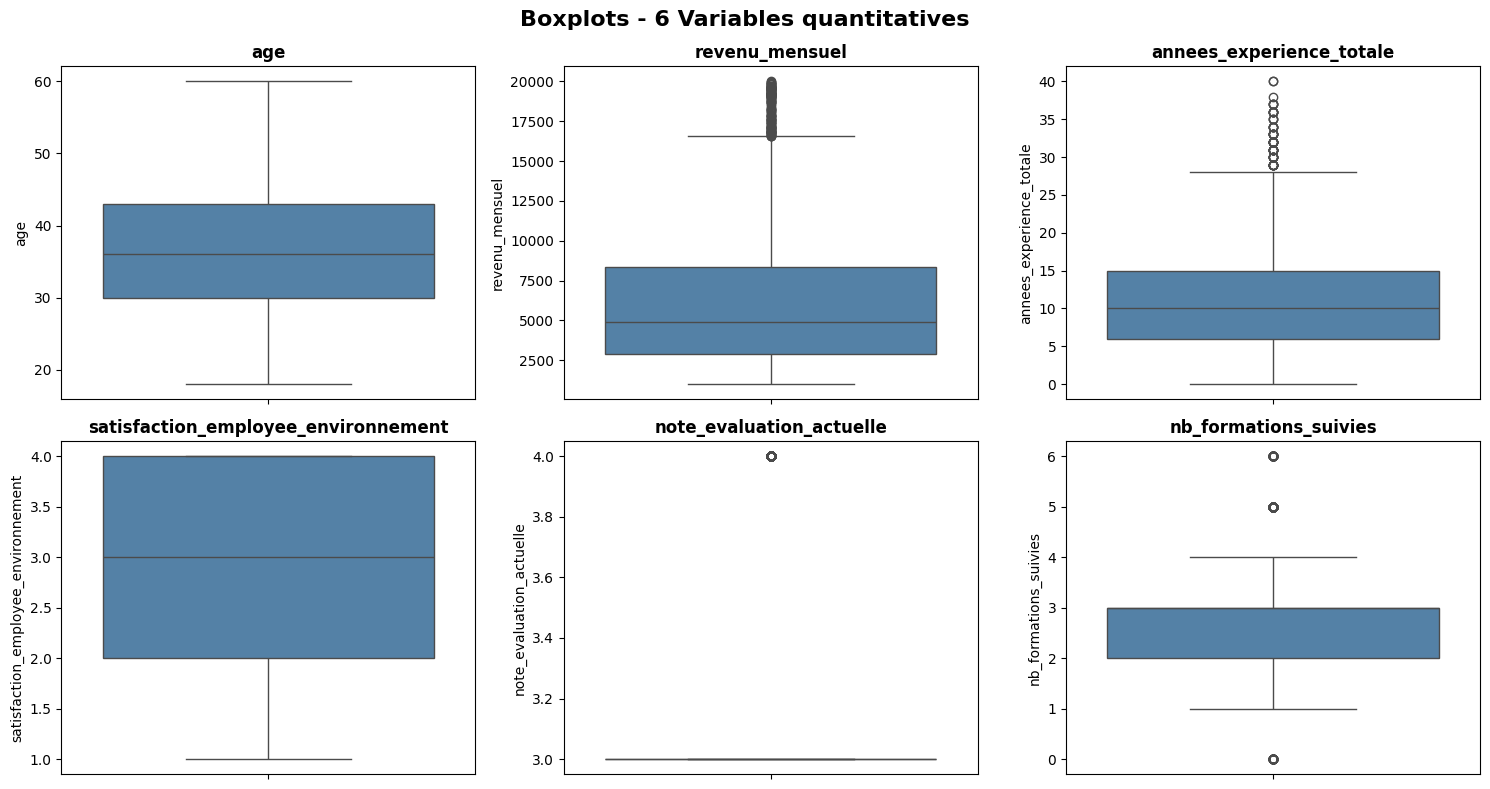

In [17]:
vars_principales = ['age', 'revenu_mensuel', 'annees_experience_totale', 
                   'satisfaction_employee_environnement', 'note_evaluation_actuelle',
                   'nb_formations_suivies']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Boxplots - 6 Variables quantitatives', 
             fontsize=16, fontweight='bold')

for i, var in enumerate(vars_principales):
    row = i // 3
    col = i % 3
    
    sns.boxplot(data=df_normalized, y=var, ax=axes[row, col], color='steelblue')
    axes[row, col].set_title(f'{var}', fontweight='bold')

plt.tight_layout()
plt.show()

### Feature Engineering

- `satisfaction_moyenne` (float) : moyenne des 4 scores de satisfaction
- `satisfaction_faible` (boolean) : 1 si la moyenne est inférieure à 2.5, sinon 0
- `stagnation_promotion` (boolean) : 1 s'il n'y a pas eu de promotion depuis 4 ans ou plus
- `evolution_evaluation` (int) : compare la note actuelle et la précédente => retourne -1, 0 ou 1
- `augmentation_faible` (boolean) : 1 si l'augmentation est inférieure à 15%
- `peu_forme` (boolean) : 1 si l'employé a suivi 1 formation ou moins
- `distance_excessive` (boolean) : 1 si la distance domicile-travail est supérieure à 20 km
- `nouveau_poste` (boolean) : 1 si l'employé est dans le poste depuis 1 an ou moins
- `nouveau_entreprise` (boolean) : 1 si l'employé est dans l'entreprise depuis 2 ans ou moins
- `revenu_vs_median` (float) : salaire de l'employé / médiane des salaires
- `experience_ratio` (float) : expérience totale / âge (détecte les carrières précoces)
- `mobilite_ratio` (float) : années dans le poste / (années dans l'entreprise + 1)
- `age_squared` (int) : âge au carré 
- `satisfaction_squared` (float) : satisfaction moyenne au carré
- `experience_squared` (int) : années d'expérience au carré 
- `revenu_category` (int) : catégorie de revenu [0: faible, 1: moyen, 2: élevé] basée sur les quantiles

In [ ]:
df_engineered = df_normalized.copy()

# satisfaction_moyenne
df_engineered['satisfaction_moyenne'] = df_engineered[['satisfaction_employee_environnement',
                                                      'satisfaction_employee_nature_travail',
                                                      'satisfaction_employee_equipe',
                                                      'satisfaction_employee_equilibre_pro_perso']].mean(axis=1)

# satisfaction_faible
df_engineered['satisfaction_faible'] = df_engineered['satisfaction_moyenne'].apply(lambda x: 1 if x <= 2.5 else 0)

# stagnation_promotion
df_engineered['stagnation_promotion'] = df_engineered['annees_depuis_la_derniere_promotion'].apply(
    lambda x: 1 if x >= 4 else 0
)

# evolution_evaluation
df_engineered['evolution_evaluation'] = (df_engineered['note_evaluation_actuelle'] - df_engineered['note_evaluation_precedente']).apply(
    lambda x: 1 if x > 0 else (-1 if x < 0 else 0)
)

# augmentation_faible
df_engineered['augmentation_faible'] = df_engineered['augmentation_salaire_precedente'].apply(
    lambda x: 1 if x < 0.15 else 0
)

# peu_forme
df_engineered['peu_forme'] = df_engineered['nb_formations_suivies'].apply(lambda x: 1 if x <= 1 else 0)

# distance_excessive
df_engineered['distance_excessive'] = df_engineered['distance_domicile_travail'].apply(lambda x: 1 if x > 20 else 0)

# nouveau_poste
df_engineered['nouveau_poste'] = df_engineered['annees_dans_le_poste_actuel'].apply(lambda x: 1 if x <= 1 else 0)

# nouveau_entreprise
df_engineered['nouveau_entreprise'] = df_engineered['annees_dans_l_entreprise'].apply(lambda x: 1 if x <= 2 else 0)

# revenu_vs_median
revenu_median = df_engineered['revenu_mensuel'].median()
df_engineered['revenu_vs_median'] = df_engineered['revenu_mensuel'] / revenu_median

# experience_ratio
df_engineered['experience_ratio'] = df_engineered['annees_experience_totale'] / df_engineered['age']

# mobilite_ratio
df_engineered['mobilite_ratio'] = df_engineered['annees_dans_le_poste_actuel'] / (df_engineered['annees_dans_l_entreprise'] + 1)

# age_squared
df_engineered['age_squared'] = df_engineered['age'] ** 2

# satisfaction_squared
df_engineered['satisfaction_squared'] = df_engineered['satisfaction_moyenne'] ** 2

# experience_squared
df_engineered['experience_squared'] = df_engineered['annees_experience_totale'] ** 2

# revenu_category basé sur les quantiles
df_engineered['revenu_category'] = pd.qcut(
    df_engineered['revenu_mensuel'],
    q=3,
    labels=[0, 1, 2]
).astype(int)

# supprime les 4 colonnes de satisfaction individuelles (gardées dans satisfaction_moyenne)
df_engineered = df_engineered.drop(columns=[
    'satisfaction_employee_environnement',
    'satisfaction_employee_nature_travail',
    'satisfaction_employee_equipe',
    'satisfaction_employee_equilibre_pro_perso'
])

# supprime id_employee
df_engineered = df_engineered.drop(columns=['id_employee'])

# supprime revenu_mensuel (gardé dans revenu_vs_median et revenu_category)
df_engineered = df_engineered.drop(columns=['revenu_mensuel'])

In [19]:
df_engineered.head()

,age,genre,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travaillees,annees_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,...,distance_excessive,nouveau_poste,nouveau_entreprise,revenu_vs_median,experience_ratio,mobilite_ratio,age_squared,satisfaction_squared,experience_squared,revenu_category
0,41,F,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4,...,0,0,0,1.218337,0.195122,0.571429,1681,4.0000,64,1
1,49,M,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7,...,0,0,0,1.042895,0.204082,0.636364,2401,9.0000,100,1
2,37,M,Célibataire,Consulting,Consultant,6,80,7,0,0,...,0,1,1,0.424883,0.189189,0.000000,1369,9.0000,49,0
3,33,F,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7,...,0,0,0,0.591380,0.242424,0.777778,1089,10.5625,64,0
4,27,M,Marié(e),Consulting,Consultant,9,80,6,2,2,...,0,0,1,0.705021,0.222222,0.666667,729,6.2500,36,0


## Validation globale de la qualité des données

In [20]:
# Recherche des doublons
print("\n1. Recherche des doublons :")
print(f"   - SIRH: {sirh_df.duplicated().sum()}")
print(f"   - Évaluation: {eval_df.duplicated().sum()}")
print(f"   - Sondage: {sondage_df.duplicated().sum()}")

# Détection des salaires négatifs
if 'revenu_mensuel' in sirh_df.columns:
    salaires_negatifs = (sirh_df['revenu_mensuel'] < 0).sum()
    print(f"\n2. Salaires négatifs: {salaires_negatifs}")

# Vérification si première année d'expérience < 18
if all(col in sirh_df.columns for col in ['age', 'annees_dans_l_entreprise']):
    age_embauche = sirh_df['age'] - sirh_df['annees_dans_l_entreprise']
    probleme_age = (age_embauche < 18).sum()
    print(f"\n3. Employés embauchés avant 18 ans: {probleme_age}")

# Âge supérieur à l'âge d'entrée en entreprise + années d'entreprise
if all(col in sirh_df.columns for col in ['age', 'annees_dans_l_entreprise']):
    incoherence_temporelle = (sirh_df['annees_dans_l_entreprise'] > sirh_df['age']).sum()
    print(f"\n4. Incohérences temporelles: {incoherence_temporelle}")


1. Recherche des doublons :
   - SIRH: 0
   - Évaluation: 0
   - Sondage: 0

2. Salaires négatifs: 0

3. Employés embauchés avant 18 ans: 0

4. Incohérences temporelles: 0


## 4. Construction des modèles de baseline

### Preprocessing des données

In [21]:
df_model = df_engineered.copy()

# Supprimer les colonnes inutiles AVANT de définir X et y
colonnes_a_supprimer = ['eval_number', 'code_sondage', "nombre_heures_travaillees", "nombre_employee_sous_responsabilite"]
df_model = df_model.drop(columns=colonnes_a_supprimer)

target = 'a_quitte_l_entreprise'
y = df_model[target]

X = df_model.drop(columns=[target])

print(f"\nNombre de features: {X.shape[1]}")
print(f"Nombre d'observations: {X.shape[0]}")
print(f"Colonnes dans X: {X.columns.tolist()}")


Nombre de features: 39
Nombre d'observations: 1470
Colonnes dans X: ['age', 'genre', 'statut_marital', 'departement', 'poste', 'nombre_experiences_precedentes', 'annees_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'note_evaluation_actuelle', 'heure_supplementaires', 'augmentation_salaire_precedente', 'nombre_participation_pee', 'nb_formations_suivies', 'distance_domicile_travail', 'niveau_education', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel', 'satisfaction_moyenne', 'satisfaction_faible', 'stagnation_promotion', 'evolution_evaluation', 'augmentation_faible', 'peu_forme', 'distance_excessive', 'nouveau_poste', 'nouveau_entreprise', 'revenu_vs_median', 'experience_ratio', 'mobilite_ratio', 'age_squared', 'satisfaction_squared', 'experience_squared', 'revenu_category']


Préprocessing

In [ ]:
# Préparation train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train = X_train.copy()
X_test = X_test.copy()

# Variables binaires => pour Label Encoding
binary_vars = ['genre', 'heure_supplementaires', 'ayant_enfants']

# Variables ordonnées => pour Ordinal Encoding
ordinal_vars = {
    'niveau_education': [1, 2, 3, 4, 5],  
    'frequence_deplacement': ['Aucun', 'Occasionnel', 'Frequent']
}

# Variables catégorielles non-ordonnées => pour One-Hot Encoding
categorical_vars = ['statut_marital', 'departement', 'poste', 'domaine_etude']

# Variables quantitatives
numeric_vars = X_train.select_dtypes(include=[np.number]).columns.tolist()
# Retirer les variables déjà traitées
numeric_vars = [col for col in numeric_vars if col not in binary_vars and col not in ordinal_vars.keys()]


# Label Encoding
label_encoders = {}
for col in binary_vars:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

# Ordinal Encoding
ordinal_encoders = {}
for col, order in ordinal_vars.items():
    oe = OrdinalEncoder(categories=[order])
    X_train[col] = oe.fit_transform(X_train[[col]]).ravel()
    X_test[col] = oe.transform(X_test[[col]]).ravel()
    ordinal_encoders[col] = oe

# One-Hot Encoding
X_train_encoded = pd.get_dummies(X_train, columns=categorical_vars, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_vars, drop_first=True)

# Assurer la cohérence des colonnes entre train et test
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for col in missing_cols:
    X_test_encoded[col] = 0

extra_cols = set(X_test_encoded.columns) - set(X_train_encoded.columns)
for col in extra_cols:
    X_train_encoded[col] = 0

# Réorganiser les colonnes pour avoir le même ordre
X_test_encoded = X_test_encoded[X_train_encoded.columns]

numeric_cols_final = [col for col in X_train_encoded.columns if col in numeric_vars]
skewness_values = {}

for col in numeric_cols_final:
    skew_val = skew(X_train_encoded[col])
    skewness_values[col] = skew_val
    
    if abs(skew_val) > 2:
        min_val = X_train_encoded[col].min()
        if min_val <= 0:
            X_train_encoded[col] = np.log1p(X_train_encoded[col] - min_val + 1)
            X_test_encoded[col] = np.log1p(X_test_encoded[col] - min_val + 1)
        else:
            X_train_encoded[col] = np.log(X_train_encoded[col])
            X_test_encoded[col] = np.log(X_test_encoded[col])


scaler = StandardScaler()
X_train_encoded[numeric_cols_final] = scaler.fit_transform(X_train_encoded[numeric_cols_final])
X_test_encoded[numeric_cols_final] = scaler.transform(X_test_encoded[numeric_cols_final])

X_train_final = X_train_encoded
X_test_final = X_test_encoded

# SMOTE
smote = SMOTE(random_state=50, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train)

### 1. Dummy

In [23]:
dummy_clf = DummyClassifier(strategy='stratified', random_state=50)
dummy_clf.fit(X_train_encoded, y_train)

dummy_pred = dummy_clf.predict(X_test_final)
dummy_proba = dummy_clf.predict_proba(X_test_final)[:, 1]

print(f"Fbeta-Score: {fbeta_score(y_test, dummy_pred, beta=2)}")
print(f"Precision: {precision_score(y_test, dummy_pred)}")
print(f"Recall: {recall_score(y_test, dummy_pred)}")

Fbeta-Score: 0.14957264957264957
Precision: 0.15217391304347827
Recall: 0.14893617021276595


In [24]:
logistic_clf = LogisticRegression(random_state=50, max_iter=1000, class_weight="balanced")
logistic_clf.fit(X_train_resampled, y_train_resampled)

logistic_pred = logistic_clf.predict(X_test_final)
logistic_proba = logistic_clf.predict_proba(X_test_final)[:, 1]

print(f"Fbeta-Score: {fbeta_score(y_test, logistic_pred, beta=2):.3f}")
print(f"Precision: {precision_score(y_test, logistic_pred):.3f}")
print(f"Recall: {recall_score(y_test, logistic_pred):.3f}")

Fbeta-Score: 0.385
Precision: 0.391
Recall: 0.383


In [25]:
rf_clf = RandomForestClassifier(n_estimators=500, random_state=50, n_jobs=-1, class_weight="balanced")
rf_clf.fit(X_train_resampled, y_train_resampled)

rf_pred = rf_clf.predict(X_test_final)
rf_proba = rf_clf.predict_proba(X_test_final)[:, 1]

print(f"FBeta-Score: {fbeta_score(y_test, rf_pred, beta=2):.3f}")
print(f"Precision: {precision_score(y_test, rf_pred):.3f}")
print(f"Recall: {recall_score(y_test, rf_pred):.3f}")

FBeta-Score: 0.213
Precision: 0.391
Recall: 0.191


In [26]:
xgb_clf = xgb.XGBClassifier(random_state=50, eval_metric='logloss')
xgb_clf.fit(X_train_resampled, y_train_resampled)

xgb_pred = xgb_clf.predict(X_test_final)
xgb_proba = xgb_clf.predict_proba(X_test_final)[:, 1]

print(f"FBeta-Score: {fbeta_score(y_test, xgb_pred, beta=2):.3f}")
print(f"Precision: {precision_score(y_test, xgb_pred):.3f}")
print(f"Recall: {recall_score(y_test, xgb_pred):.3f}")

FBeta-Score: 0.327
Precision: 0.538
Recall: 0.298


In [27]:
results = pd.DataFrame({
    'Modèle': ['Dummy', 'Logistic Regression', 'Random Forest', 'XGBoost'],
    'FBeta-Score': [
        fbeta_score(y_test, dummy_pred, beta=2),
        fbeta_score(y_test, logistic_pred, beta=2),
        fbeta_score(y_test, rf_pred, beta=2),
        fbeta_score(y_test, xgb_pred, beta=2)
    ],
    'Precision': [
        precision_score(y_test, dummy_pred),
        precision_score(y_test, logistic_pred),
        precision_score(y_test, rf_pred),
        precision_score(y_test, xgb_pred)
    ],
    'Recall': [
        recall_score(y_test, dummy_pred),
        recall_score(y_test, logistic_pred),
        recall_score(y_test, rf_pred),
        recall_score(y_test, xgb_pred)
    ]
})


results.round(3)

,Modèle,FBeta-Score,Precision,Recall
0,Dummy,0.150,0.152,0.149
1,Logistic Regression,0.385,0.391,0.383
2,Random Forest,0.213,0.391,0.191
3,XGBoost,0.327,0.538,0.298


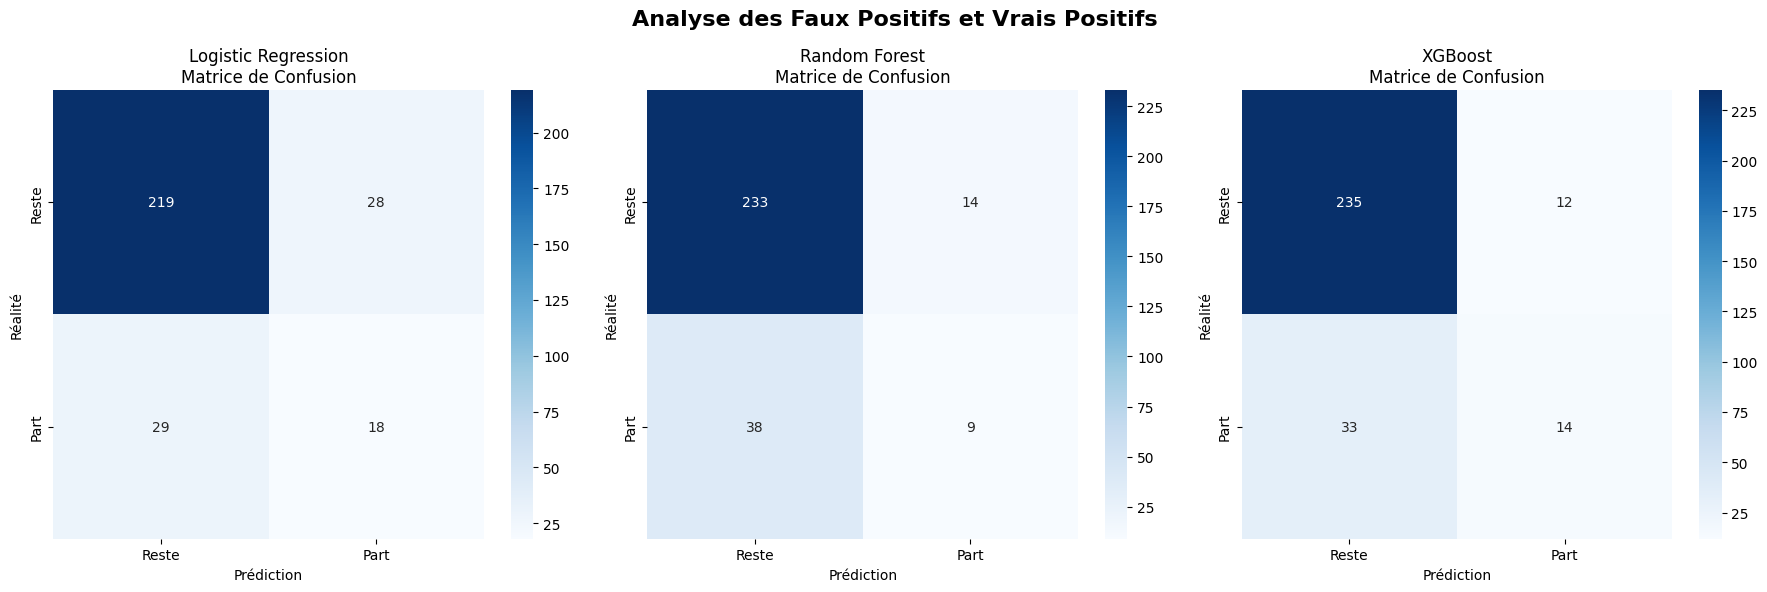

In [28]:
plt.style.use('default')
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Analyse des Faux Positifs et Vrais Positifs', fontsize=16, fontweight='bold')

models = {
    'Logistic Regression': logistic_pred,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred
}

for i, (name, pred) in enumerate(models.items()):
    cm = confusion_matrix(y_test, pred)
   
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Reste', 'Part'],
                yticklabels=['Reste', 'Part'],
                ax=axes[i])
    axes[i].set_title(f'{name}\nMatrice de Confusion')
    axes[i].set_xlabel('Prédiction')
    axes[i].set_ylabel('Réalité')

plt.tight_layout()
plt.show()

## 5. Cross-validation pour vérifier la stabilité des performances

Utilisation d'une cross-validation avec StratifiedKFold pour :
- Vérifier la stabilité des performances sur différents échantillons
- Calculer le coefficient de variation comme indicateur de stabilité



**Interprétation du coefficient de variation (CV) :**
- CV < 0.10 : Très stable
- 0.10 ≤ CV < 0.20 : Stable  
- 0.20 ≤ CV < 0.30 : Modérément stable
- CV ≥ 0.30 : Instable


In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=50)
beta = 2

models = {
    'Dummy': DummyClassifier(strategy='stratified', random_state=50),
    'Logistic Regression': LogisticRegression(random_state=50, max_iter=1000, class_weight="balanced"),
    'Random Forest': RandomForestClassifier(n_estimators=500, random_state=50, n_jobs=-1, class_weight="balanced"),
    'XGBoost': xgb.XGBClassifier(random_state=50, eval_metric='logloss', scale_pos_weight=5)
}

cv_results = {
    'model': [],
    'fold': [],
    'fbeta_score': [],
    'precision': [],
    'recall': []
}

for model_name, model in models.items():
    print(f"\n{model_name}")
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_final, y_train)):
        X_cv_train, X_cv_val = X_train_final.iloc[train_idx], X_train_final.iloc[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_cv_train, y_cv_train)
        y_pred = model.predict(X_cv_val)

        fbeta = fbeta_score(y_cv_val, y_pred, beta=beta, zero_division=0)
        precision = precision_score(y_cv_val, y_pred, zero_division=0)
        recall = recall_score(y_cv_val, y_pred, zero_division=0)

        cv_results['model'].append(model_name)
        cv_results['fold'].append(fold + 1)
        cv_results['fbeta_score'].append(fbeta)
        cv_results['precision'].append(precision)
        cv_results['recall'].append(recall)
        
        print(f"  Fold {fold + 1}: FBeta={fbeta:.3f}, Precision={precision:.3f}, Recall={recall:.3f}")


Dummy
  Fold 1: FBeta=0.152, Precision=0.130, Recall=0.158
  Fold 2: FBeta=0.354, Precision=0.304, Recall=0.368
  Fold 3: FBeta=0.253, Precision=0.217, Recall=0.263
  Fold 4: FBeta=0.253, Precision=0.217, Recall=0.263
  Fold 5: FBeta=0.101, Precision=0.087, Recall=0.105
  Fold 6: FBeta=0.202, Precision=0.174, Recall=0.211
  Fold 7: FBeta=0.101, Precision=0.087, Recall=0.105
  Fold 8: FBeta=0.101, Precision=0.087, Recall=0.105
  Fold 9: FBeta=0.202, Precision=0.174, Recall=0.211
  Fold 10: FBeta=0.253, Precision=0.217, Recall=0.263

Logistic Regression
  Fold 1: FBeta=0.714, Precision=0.517, Recall=0.789
  Fold 2: FBeta=0.676, Precision=0.429, Recall=0.789
  Fold 3: FBeta=0.746, Precision=0.447, Recall=0.895
  Fold 4: FBeta=0.746, Precision=0.447, Recall=0.895
  Fold 5: FBeta=0.652, Precision=0.385, Recall=0.789
  Fold 6: FBeta=0.588, Precision=0.462, Recall=0.632
  Fold 7: FBeta=0.509, Precision=0.344, Recall=0.579
  Fold 8: FBeta=0.545, Precision=0.353, Recall=0.632
  Fold 9: FBeta=0

In [30]:
cv_df = pd.DataFrame(cv_results)

def calculate_cv(group):
    cv_dict = {}
    for metric in ['fbeta_score', 'precision', 'recall']:
        mean_val = group[metric].mean()
        std_val = group[metric].std()
        cv_dict[f'{metric}_cv'] = (std_val / mean_val) if mean_val > 0 else 0
    return pd.Series(cv_dict)

cv_stability = cv_df.groupby('model').apply(calculate_cv).round(4)

cv_stability


,fbeta_score_cv,precision_cv,recall_cv
model,,,
Dummy,0.4265,0.4265,0.4265
Logistic Regression,0.1641,0.1787,0.1777
Random Forest,0.4759,0.2748,0.4903
XGBoost,0.2236,0.1520,0.2477


In [31]:
# Récupération des métriques par modèle depuis les résultats de CV
model_metrics = {}
for model_name in ['Logistic Regression', 'Random Forest', 'XGBoost']:
    # Métriques CV
    cv_model_data = cv_df[cv_df['model'] == model_name]
    fbeta_mean = cv_model_data['fbeta_score'].mean()
    fbeta_std = cv_model_data['fbeta_score'].std()
    precision_mean = cv_model_data['precision'].mean()
    recall_mean = cv_model_data['recall'].mean()
    
    # Coefficient de variation
    cv_coeff = (fbeta_std / fbeta_mean) if fbeta_mean > 0 else 0
    
    model_metrics[model_name] = {
        'cv_fbeta_mean': fbeta_mean,
        'cv_fbeta_std': fbeta_std,
        'cv_precision_mean': precision_mean,
        'cv_recall_mean': recall_mean,
        'cv_coefficient': cv_coeff
    }


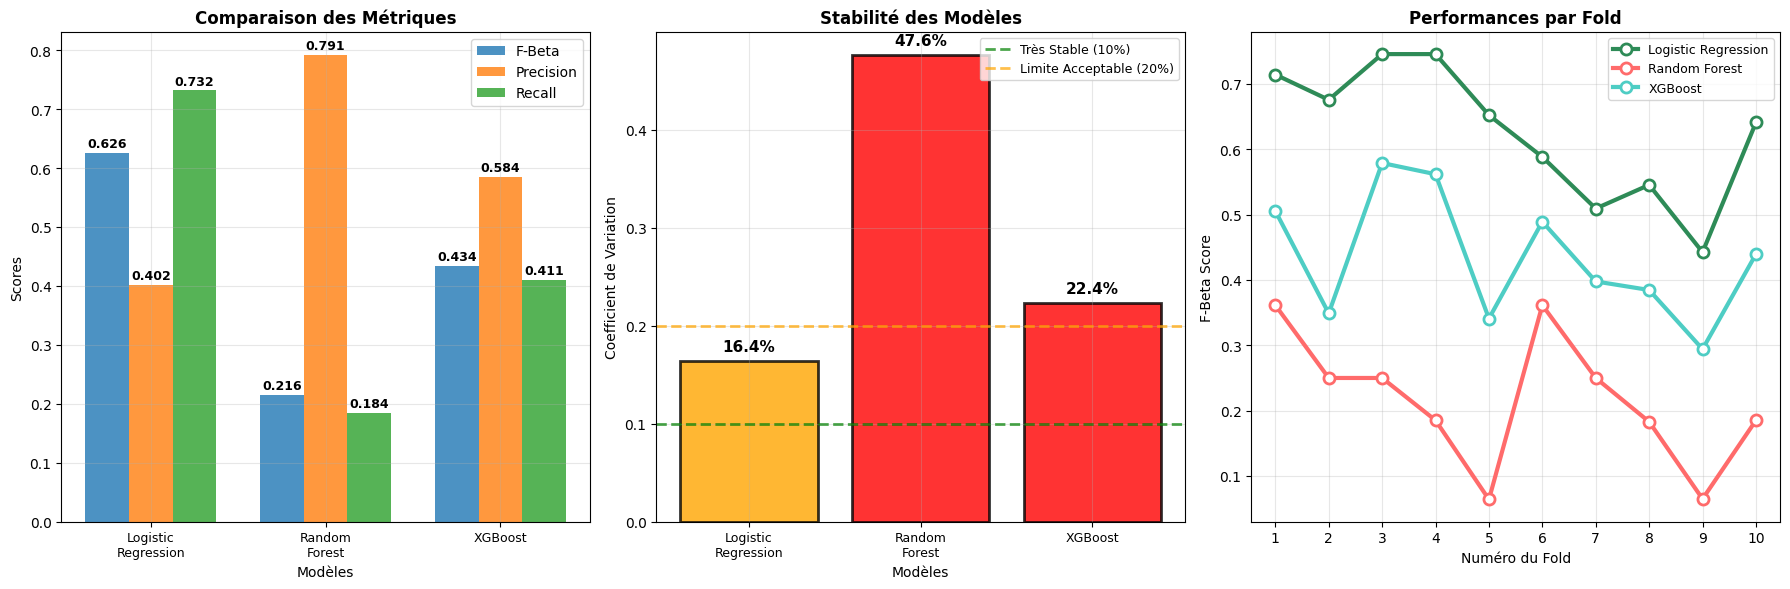

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors = ['#2E8B57', '#FF6B6B', '#4ECDC4']  
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
model_names = list(model_metrics.keys())

ax = axes[0]
x = np.arange(len(model_names))
width = 0.25

fbeta_scores = [model_metrics[m]['cv_fbeta_mean'] for m in model_names]
precision_scores = [model_metrics[m]['cv_precision_mean'] for m in model_names]
recall_scores = [model_metrics[m]['cv_recall_mean'] for m in model_names]

bars1 = ax.bar(x - width, fbeta_scores, width, label='F-Beta', color='#1f77b4', alpha=0.8)
bars2 = ax.bar(x, precision_scores, width, label='Precision', color='#ff7f0e', alpha=0.8)
bars3 = ax.bar(x + width, recall_scores, width, label='Recall', color='#2ca02c', alpha=0.8)

for i, (fb, pr, rc) in enumerate(zip(fbeta_scores, precision_scores, recall_scores)):
    ax.text(i - width, fb + 0.01, f'{fb:.3f}', ha='center', fontsize=9, fontweight='bold')
    ax.text(i, pr + 0.01, f'{pr:.3f}', ha='center', fontsize=9, fontweight='bold')
    ax.text(i + width, rc + 0.01, f'{rc:.3f}', ha='center', fontsize=9, fontweight='bold')

ax.set_xlabel('Modèles')
ax.set_ylabel('Scores')
ax.set_title('Comparaison des Métriques', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([name.replace(' ', '\n') for name in model_names], fontsize=9)
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
cvs = [model_metrics[m]['cv_coefficient'] for m in model_names]
colors_stability = ['green' if cv < 0.10 else 'orange' if cv < 0.20 else 'red' for cv in cvs]

bars = ax.bar(range(len(model_names)), cvs,
              color=colors_stability, alpha=0.8, edgecolor='black', linewidth=2)

for i, cv in enumerate(cvs):
    ax.text(i, cv + 0.01, f'{cv:.1%}',
            ha='center', fontsize=11, fontweight='bold')

ax.axhline(y=0.10, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Très Stable (10%)')
ax.axhline(y=0.20, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Limite Acceptable (20%)')

ax.set_xlabel('Modèles')
ax.set_ylabel('Coefficient de Variation')
ax.set_title('Stabilité des Modèles', fontweight='bold')
ax.set_xticks(range(len(model_names)))
ax.set_xticklabels([name.replace(' ', '\n') for name in model_names], fontsize=9)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

ax = axes[2]

folds = list(range(1, 11))

for i, model in enumerate(models):
    model_scores = cv_df[cv_df['model'] == model]['fbeta_score'].tolist()
    ax.plot(folds, model_scores, 'o-', linewidth=3, markersize=8,
            color=colors[i], label=model, markerfacecolor='white',
            markeredgewidth=2, markeredgecolor=colors[i])

ax.set_xlabel('Numéro du Fold')
ax.set_ylabel('F-Beta Score')
ax.set_title('Performances par Fold', fontweight='bold')
ax.set_xticks(folds)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Comparaison des modèles avec ajustement de seuil optimal

Optimisation du seuil de classification pour chaque modèle afin d'identifier le meilleur modèle avec le meilleur seuil.

In [33]:
models_comparison = []
best_thresholds = {}

logistic_clf = LogisticRegression(
    random_state=50,
    max_iter=1000,
    class_weight="balanced"
)
logistic_clf.fit(X_train_resampled, y_train_resampled)
logistic_proba = logistic_clf.predict_proba(X_test_final)[:, 1]


rf_clf = RandomForestClassifier(
    n_estimators=500,
    random_state=50,
    n_jobs=-1,
    class_weight="balanced"
)
rf_clf.fit(X_train_resampled, y_train_resampled)
rf_proba = rf_clf.predict_proba(X_test_final)[:, 1]

xgb_clf = xgb.XGBClassifier(
    random_state=50,
    eval_metric='logloss'
)
xgb_clf.fit(X_train_resampled, y_train_resampled)
xgb_proba = xgb_clf.predict_proba(X_test_final)[:, 1]


models_dict = {
    'Logistic Regression': (logistic_clf, logistic_proba),
    'Random Forest': (rf_clf, rf_proba),
    'XGBoost': (xgb_clf, xgb_proba)
}

for model_name, (model, probas) in models_dict.items():
    seuils = np.arange(0.05, 0.95, 0.01) 
    threshold_results = []

    for seuil in seuils:
        y_pred_custom = (probas >= seuil).astype(int)

        if y_pred_custom.sum() == 0:
            continue

        fbeta = fbeta_score(y_test, y_pred_custom, beta=2, zero_division=0)
        precision = precision_score(y_test, y_pred_custom, zero_division=0)
        recall = recall_score(y_test, y_pred_custom, zero_division=0)


        threshold_results.append({
            'seuil': seuil,
            'fbeta': fbeta,
            'precision': precision,
            'recall': recall
        })

    df_threshold = pd.DataFrame(threshold_results)

    best_idx = df_threshold['fbeta'].idxmax()
    best_threshold = df_threshold.loc[best_idx, 'seuil']
    best_fbeta = df_threshold.loc[best_idx, 'fbeta']
    best_precision = df_threshold.loc[best_idx, 'precision']
    best_recall = df_threshold.loc[best_idx, 'recall']

    best_thresholds[model_name] = best_threshold

   
    models_comparison.append({
        'Modèle': model_name,
        'Seuil optimal': best_threshold,
        'F-Beta optimal': best_fbeta,
        'Precision optimale': best_precision,
        'Recall optimal': best_recall,
    })


pd.DataFrame(models_comparison).round(3)

,Modèle,Seuil optimal,F-Beta optimal,Precision optimale,Recall optimal
0,Logistic Regression,0.16,0.531,0.268,0.702
1,Random Forest,0.19,0.580,0.264,0.830
2,XGBoost,0.05,0.541,0.394,0.596


## GridSearch pour Random Forest

In [ ]:
param_grid = {
    'rf__n_estimators': [500, 700],
    'rf__max_depth': [15, 20, None],
    'rf__min_samples_split': [10, 20],
    'rf__min_samples_leaf': [5, 10],
    'rf__max_features': ['sqrt'],
    'rf__class_weight': ['balanced'],
    'rf__max_samples': [0.8, None]
}

pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=50, k_neighbors=5)),
    ('rf', RandomForestClassifier(random_state=50, n_jobs=-1))
])

def fbeta_scorer(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

fbeta_scorer_cv = make_scorer(fbeta_scorer)

grid = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=50), 
    n_jobs=-1, 
    scoring=fbeta_scorer_cv,
    verbose=2
)

grid.fit(X_train_final, y_train)

print("\nMeilleurs paramètres:", grid.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits

Meilleurs paramètres: {'rf__class_weight': 'balanced', 'rf__max_depth': 15, 'rf__max_features': 'sqrt', 'rf__max_samples': 0.8, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 10, 'rf__n_estimators': 500}


In [ ]:
best_rf = grid.best_estimator_
best_rf_proba = best_rf.predict_proba(X_test_final)[:, 1]

# Recherche du seuil optimal
seuils = np.arange(0.05, 0.95, 0.01)
threshold_results = []

for seuil in seuils:
    y_pred_custom = (best_rf_proba >= seuil).astype(int)
    
    if y_pred_custom.sum() == 0:
        continue
    
    fbeta = fbeta_score(y_test, y_pred_custom, beta=2, zero_division=0)
    precision = precision_score(y_test, y_pred_custom, zero_division=0)
    recall = recall_score(y_test, y_pred_custom, zero_division=0)
    
    threshold_results.append({
        'seuil': seuil,
        'fbeta': fbeta,
        'precision': precision,
        'recall': recall
    })

df_threshold = pd.DataFrame(threshold_results)

best_idx = df_threshold['fbeta'].idxmax()
best_threshold = df_threshold.loc[best_idx, 'seuil']
best_fbeta = df_threshold.loc[best_idx, 'fbeta']
best_precision = df_threshold.loc[best_idx, 'precision']
best_recall = df_threshold.loc[best_idx, 'recall']

best_rf_pred_optimal = (best_rf_proba >= best_threshold).astype(int)

print(f"Seuil optimal: {best_threshold:.2f}")
print(f"F-Beta Score: {best_fbeta:.3f}")
print(f"Precision: {best_precision:.3f}")
print(f"Recall: {best_recall:.3f}")

<Figure size 1200x800 with 0 Axes>

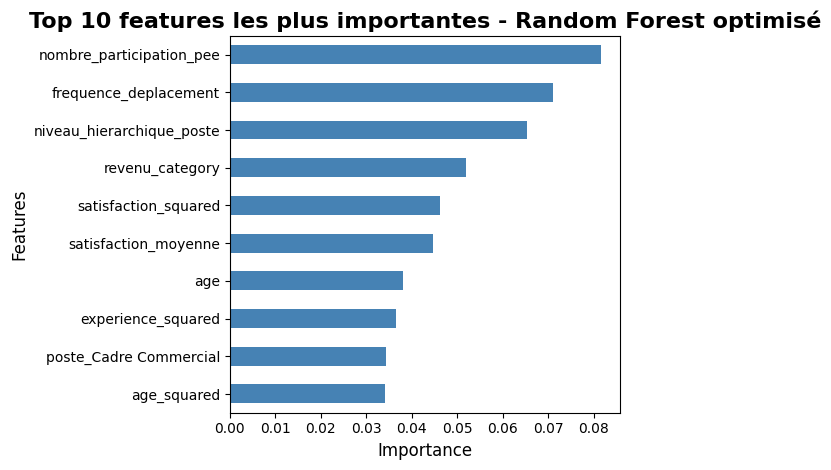

In [ ]:
importances = grid.best_estimator_.named_steps['rf'].feature_importances_
feat_names = X_train_final.columns

imp_df = pd.DataFrame({
    "Feature": feat_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 8))
imp_df.head(10).plot(kind="barh", x="Feature", y="Importance", legend=False, color='steelblue')
plt.gca().invert_yaxis()
plt.title("Top 10 features les plus importantes - Random Forest optimisé", fontsize=16, fontweight='bold')
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

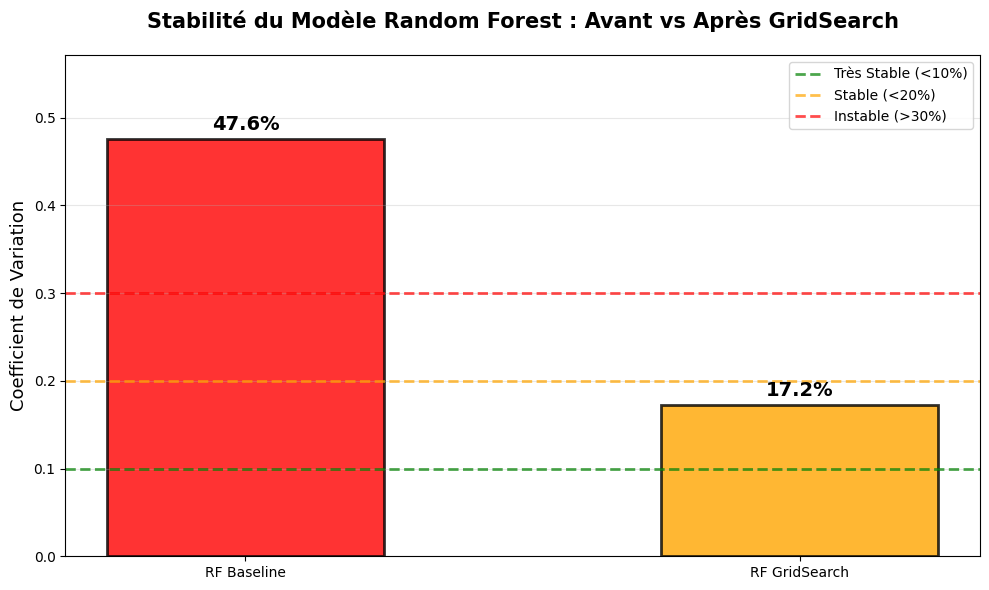

In [ ]:
# Stabilité du RF baseline depuis la cross-validation
rf_baseline_cv_data = cv_df[cv_df['model'] == 'Random Forest']
rf_baseline_fbeta_cv = rf_baseline_cv_data['fbeta_score'].mean()
rf_baseline_fbeta_std_cv = rf_baseline_cv_data['fbeta_score'].std()
rf_baseline_cv_coeff = (rf_baseline_fbeta_std_cv / rf_baseline_fbeta_cv) if rf_baseline_fbeta_cv > 0 else 0

best_params = grid.best_params_

# Extraire les paramètres du modèle RF
rf_params = {k.replace('rf__', ''): v for k, v in best_params.items()}
rf_grid_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=50, k_neighbors=5)),
    ('rf', RandomForestClassifier(**rf_params, random_state=50, n_jobs=-1))
])

cv_grid = StratifiedKFold(n_splits=10, shuffle=True, random_state=50)
grid_cv_scores = []

for fold, (train_idx, val_idx) in enumerate(cv_grid.split(X_train_final, y_train)):
    X_cv_train, X_cv_val = X_train_final.iloc[train_idx], X_train_final.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    rf_grid_pipeline.fit(X_cv_train, y_cv_train)
    y_pred = rf_grid_pipeline.predict(X_cv_val)
    
    fbeta = fbeta_score(y_cv_val, y_pred, beta=2)
    grid_cv_scores.append(fbeta)

rf_grid_fbeta_cv_mean = np.mean(grid_cv_scores)
rf_grid_fbeta_cv_std = np.std(grid_cv_scores)
rf_grid_cv_coeff = (rf_grid_fbeta_cv_std / rf_grid_fbeta_cv_mean) if rf_grid_fbeta_cv_mean > 0 else 0

fig, ax = plt.subplots(figsize=(10, 6))

models_labels = ['RF Baseline', 'RF GridSearch']
cv_coefficients = [rf_baseline_cv_coeff, rf_grid_cv_coeff]

colors_stability = []
for cv_coeff in cv_coefficients:
    if cv_coeff < 0.10:
        colors_stability.append('green')
    elif cv_coeff < 0.20:
        colors_stability.append('orange')
    else:
        colors_stability.append('red')

bars = ax.bar(models_labels, cv_coefficients, color=colors_stability, 
              alpha=0.8, edgecolor='black', linewidth=2, width=0.5)

for i, cv_coeff in enumerate(cv_coefficients):
    ax.text(i, cv_coeff + 0.01, f'{cv_coeff:.1%}',
            ha='center', fontsize=14, fontweight='bold')


ax.axhline(y=0.10, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Très Stable (<10%)')
ax.axhline(y=0.20, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Stable (<20%)')
ax.axhline(y=0.30, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Instable (>30%)')

ax.set_ylabel('Coefficient de Variation', fontsize=13)
ax.set_title('Stabilité du Modèle Random Forest : Avant vs Après GridSearch', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, max(cv_coefficients) * 1.2)

plt.tight_layout()
plt.show()

## Analyse SHAP 

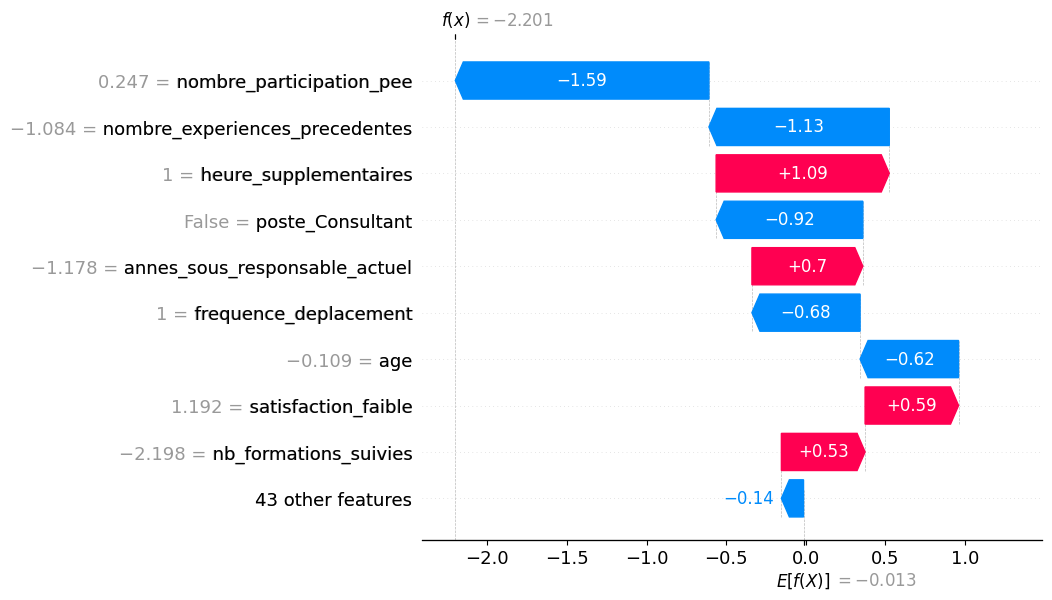

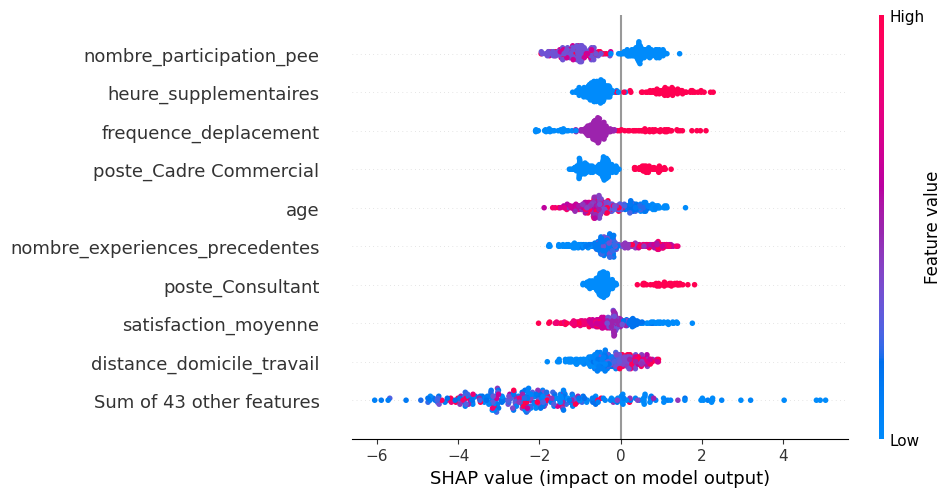

In [40]:
X_test_df = pd.DataFrame(
    X_test_final, 
    columns=X_test_final.columns
)

explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test_df)


idx_depart = y_test[y_test == 1].index[0] 
idx_in_test = X_test_df.index.get_loc(idx_depart)

shap.plots.waterfall(shap.Explanation(
    values=shap_values[idx_in_test],
    base_values=explainer.expected_value,
    data=X_test_df.iloc[idx_in_test],
    feature_names=X_test_df.columns.tolist()
))

shap.plots.beeswarm(shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test_df,
    feature_names=X_test_df.columns.tolist()
), max_display=10)